# Modeling Mobi Bike Usage

Mobi data scraped using custom code from Mobi's public API. Weather data similarly pulled from Environment Canada with custom code.

Inspired by an example in Jake Vanderplas' [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook)

In [1]:
%matplotlib notebook
from vanweather import get_weather_range

In [2]:
#Load mobi daily data
thdf = pd.read_pickle('taken_hourly_df.p')
thdf = thdf.drop_duplicates()
tddf = thdf.groupby(pd.TimeGrouper(freq='D')).sum()
tddf.sum(1).tail()

time
2017-12-17 00:00:00-08:00    225.0
2017-12-18 00:00:00-08:00    974.0
2017-12-19 00:00:00-08:00    284.0
2017-12-20 00:00:00-08:00    755.0
2017-12-21 00:00:00-08:00    481.0
Freq: D, dtype: float64

In [3]:
# Missing data days. Days when my computer was down and only partial data was acquired
tddf.loc['2017-06-24'] = np.nan
tddf.loc['2017-06-25'] = np.nan
tddf.loc['2017-04-17'] = np.nan
tddf.loc['2017-05-19'] = np.nan
tddf.loc['2017-05-10'] = np.nan


In [10]:
# Arbitrary cutoff at November 1st
tddf = tddf.loc[:'2017-11-01']

In [14]:
# Get weather data from custom code
wdf = get_weather_range((2017,4),(2017,11)).fillna(method='pad')
wdf = wdf.tz_localize('US/Pacific') # Needs to match mobi df or they won't interact well
wdf.head()


,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rainmm,Total Snowcm,Total Precipmm,Snow on Grndcm,Dir of Max Gust10's deg,Spd of Max Gustkm/h
Day,,,,,,,,,,,
2017-04-01 00:00:00-07:00,10.8,6.4,8.6,9.4,0.0,11.2,0.0,11.2,NaN,26.0,41.0
2017-04-02 00:00:00-07:00,10.6,5.7,8.2,9.8,0.0,0.0,0.0,0.0,NaN,27.0,52.0
2017-04-03 00:00:00-07:00,10.3,1.7,6.0,12.0,0.0,0.0,0.0,0.0,NaN,27.0,52.0
2017-04-04 00:00:00-07:00,13.8,4.7,9.3,8.7,0.0,7.2,0.0,7.2,NaN,14.0,57.0
2017-04-05 00:00:00-07:00,11.1,8.2,9.7,8.3,0.0,13.4,0.0,13.4,NaN,15.0,41.0


In [22]:
# only take dates that we have in the mobi data
wdf = wdf[tddf.index[0]:tddf.index[-1]]

# Add trips data to weather dataframe
wdf['Trips'] = tddf.sum(1)

In [23]:
# Functions for highlighting weekends on plots

from datetime import datetime, timedelta

def find_weekend_indices(datetime_array):
    indices=[]
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() in [4,5] :
            indices.append(i+1)
    return indices

def highlight_weekend(datetime_array,weekend_indices,ax):
    td = timedelta(hours=12)
    for i in weekend_indices:
        try:
            ax.axvspan(datetime_array[i]-td, datetime_array[i+1]-td, facecolor='gray', edgecolor='none', alpha=.2)
        except:
            pass

In [24]:
def make_weather_plot(date1='2017-04-20',date2=datetime.today().strftime('%Y-%m-%d')):
    f,(ax,wax) = plt.subplots(2,sharex=True,gridspec_kw={'height_ratios':[4.5,1]})

    df = wdf.loc[date1:date2]
    
    
    ax.plot(df.index,df['Trips'],color='green')
    ax.fill_between(df.index,df['Trips'],color='green',alpha=0.5)
    #ax.set_ylim([0,4000])
    ax.set_ylabel('Number of trips')

    wax.bar(df.index,df['Total Rainmm'],color='blue',alpha=0.5)
    wax.plot(df.index,df['Max Temp'],color='yellow')
    wax.set_ylabel('$^\circ$C, mm')
    #wax.plot(wdf.index,wdf['Max Temp'])

    weekend_indices = find_weekend_indices(wdf.index)
    highlight_weekend(df.index,weekend_indices,ax)
    highlight_weekend(df.index,weekend_indices,wax)

    for tick in wax.get_xticklabels():
        tick.set_rotation(45)
    f.subplots_adjust(wspace=0, hspace=0)
    f.tight_layout()
    f.savefig('weather_plot_{}-{}'.format(date1,date2))

<IPython.core.display.Javascript object>


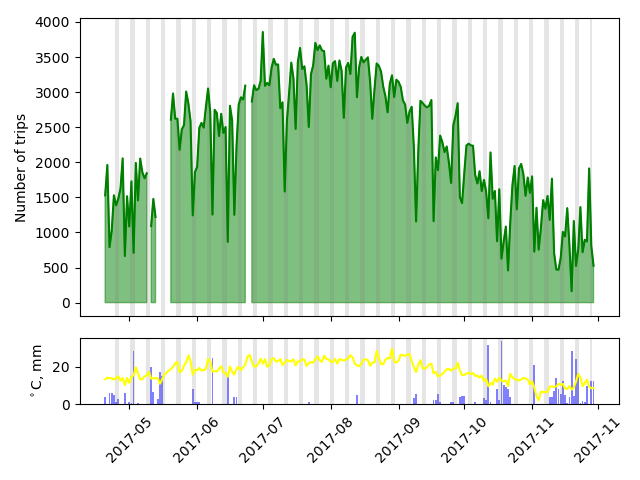

In [25]:
make_weather_plot()

<IPython.core.display.Javascript object>


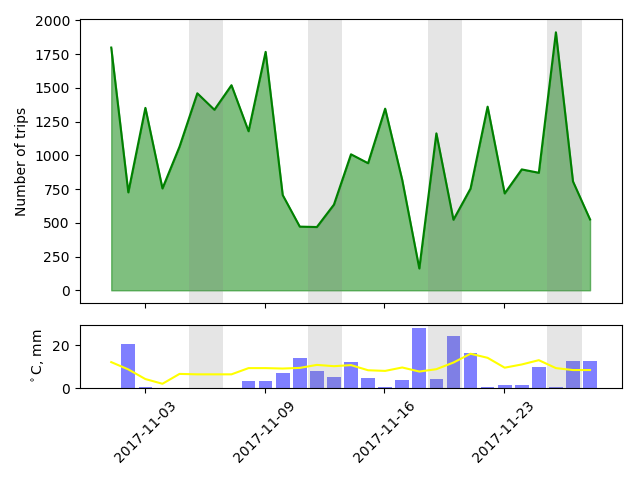

In [27]:
make_weather_plot('2017-11')

<IPython.core.display.Javascript object>


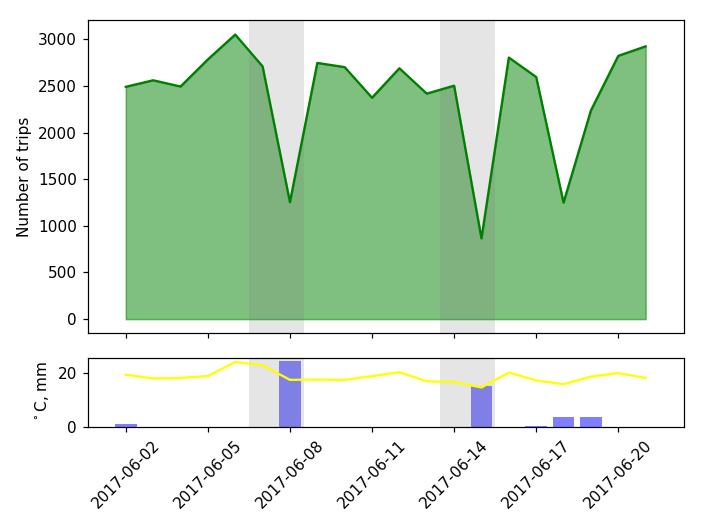

In [81]:
make_weather_plot('2017-06-02','2017-06-21')

# Correlations

First, look at individual correlations between different weather measures

In [82]:
# Add columns for weekday vs weekend and day of week
wdf['isWeekday'] = (wdf.index.weekday < 5).astype(float)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    wdf[days[i]] = (wdf.index.dayofweek == i).astype(float)

In [83]:
wdf.head()

,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rainmm,Total Snowcm,Total Precipmm,Snow on Grndcm,Dir of Max Gust10's deg,Spd of Max Gustkm/h,Trips,isWeekday,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Day,,,,,,,,,,,,,,,,,,,,
2017-04-17 00:00:00-07:00,14.0,8.6,11.3,6.7,0.0,5.4,0.0,5.4,NaN,14.0,33.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-18 00:00:00-07:00,14.3,9.1,11.7,6.3,0.0,5.2,0.0,5.2,NaN,21.0,32.0,1112.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2017-04-19 00:00:00-07:00,12.8,7.5,10.2,7.8,0.0,0.8,0.0,0.8,NaN,10.0,48.0,1296.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-04-20 00:00:00-07:00,13.2,8.5,10.9,7.1,0.0,3.6,0.0,3.6,NaN,19.0,33.0,1528.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-04-21 00:00:00-07:00,14.1,6.5,10.3,7.7,0.0,0.0,0.0,0.0,NaN,20.0,32.0,1962.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [84]:
# Add a column for stat holidays, and call holidays weekends

holidays = ['2017-05-22','2017-07-03','2017-08-07','2017-09-04','2017-10-09']

wdf['Holiday'] = 0 


# holidays are weekend-like
for holiday in holidays:
    wdf.loc[holiday,'isWeekday'] = 0
    wdf.loc[holiday,'Holiday'] = 1

In [85]:
wdf.loc['2017-06-11']

Max Temp                     18.8
Min Temp                      9.3
Mean Temp                    14.1
Heat Deg Days                 3.9
Cool Deg Days                 0.0
Total Rainmm                  0.0
Total Snowcm                  0.0
Total Precipmm                0.0
Snow on Grndcm                NaN
Dir of Max Gust10's deg      23.0
Spd of Max Gustkm/h          26.0
Trips                      2374.0
isWeekday                     0.0
Mon                           0.0
Tue                           0.0
Wed                           0.0
Thu                           0.0
Fri                           0.0
Sat                           0.0
Sun                           1.0
Holiday                       0.0
Name: 2017-06-11 00:00:00-07:00, dtype: float64

<IPython.core.display.Javascript object>


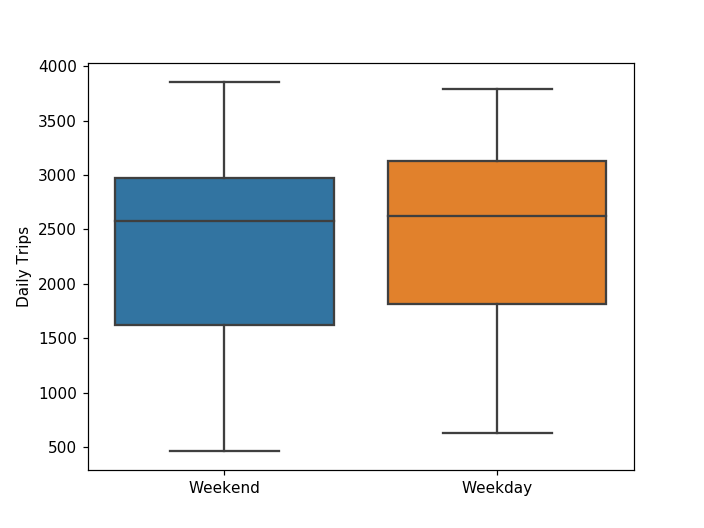

In [86]:
import seaborn as sns
f,ax = plt.subplots()

sns.boxplot(x=wdf['isWeekday'],y=tddf.sum(1))
ax.xaxis.set_ticklabels(['Weekend','Weekday'])
ax.set_ylabel('Daily Trips')
ax.set_xlabel('')
f.savefig('weekdays_vs_weekends_boxplot.png')

<IPython.core.display.Javascript object>


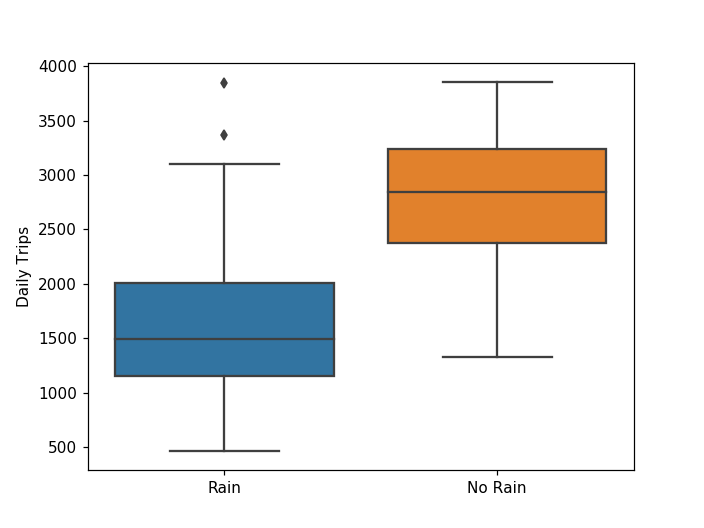

In [87]:
f,ax = plt.subplots()

#ax.boxplot([tddf[wdf['isWeekday']==True].sum(1).dropna().values,tddf[wdf['isWeekday']==False].sum(1).dropna().values])
#ax.boxplot(tddf[wdf['isWeekday']==False].sum(1).dropna().values)
sns.boxplot(x=wdf['Total Rainmm']==0.,y=tddf.sum(1))
ax.xaxis.set_ticklabels(['Rain' ,'No Rain'])
ax.set_ylabel('Daily Trips')
ax.set_xlabel('')
f.savefig('rain_vs_norain.png')

In [25]:
# Add column for dry vs wet days

wdf['Dry'] = (wdf['Total Rainmm']==0).astype(int)

In [26]:
wdf[['Dry','Total Rainmm']].head()

,Dry,Total Rainmm
Day,,
2017-04-17 00:00:00-07:00,0,5.4
2017-04-18 00:00:00-07:00,0,5.2
2017-04-19 00:00:00-07:00,0,0.8
2017-04-20 00:00:00-07:00,0,3.6
2017-04-21 00:00:00-07:00,1,0.0


In [89]:
wdf.loc['2017-10-12']

Max Temp                      9.6
Min Temp                      6.1
Mean Temp                     7.9
Heat Deg Days                10.1
Cool Deg Days                 0.0
Total Rainmm                 31.4
Total Snowcm                  0.0
Total Precipmm               31.4
Snow on Grndcm                NaN
Dir of Max Gust10's deg       6.0
Spd of Max Gustkm/h          35.0
Trips                      1201.0
isWeekday                     1.0
Mon                           0.0
Tue                           0.0
Wed                           0.0
Thu                           1.0
Fri                           0.0
Sat                           0.0
Sun                           0.0
Holiday                       0.0
Name: 2017-10-12 00:00:00-07:00, dtype: float64

<IPython.core.display.Javascript object>


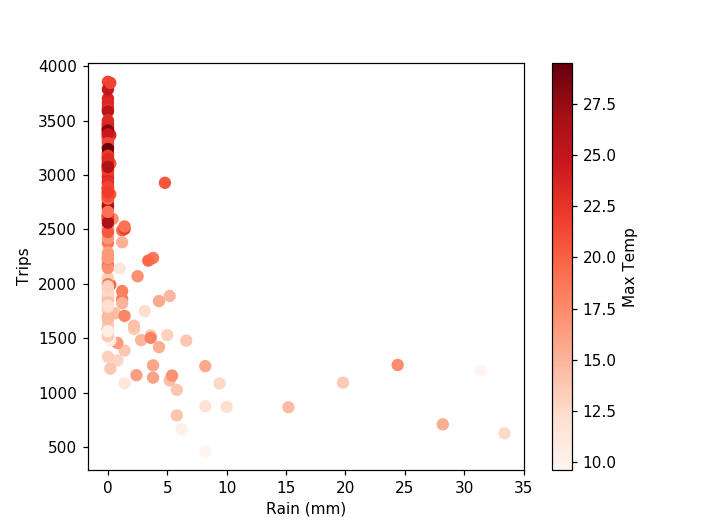

In [27]:
f,ax = plt.subplots()
wdf.plot('Total Rainmm','Trips',ax=ax,kind='scatter',cmap='Reds',c='Max Temp',s=50)
ax.set_xlabel('Rain (mm)')
f.savefig('trips_vs_rainfall.png')

In [28]:
wdf = wdf.dropna(subset=['Trips'])

In [29]:
m,resids,rank, sing, rcond = np.polyfit(wdf['Total Rainmm'],wdf['Trips'],1,full=True)

In [30]:
rainfit = np.polyval(m,wdf['Total Rainmm'])

<IPython.core.display.Javascript object>


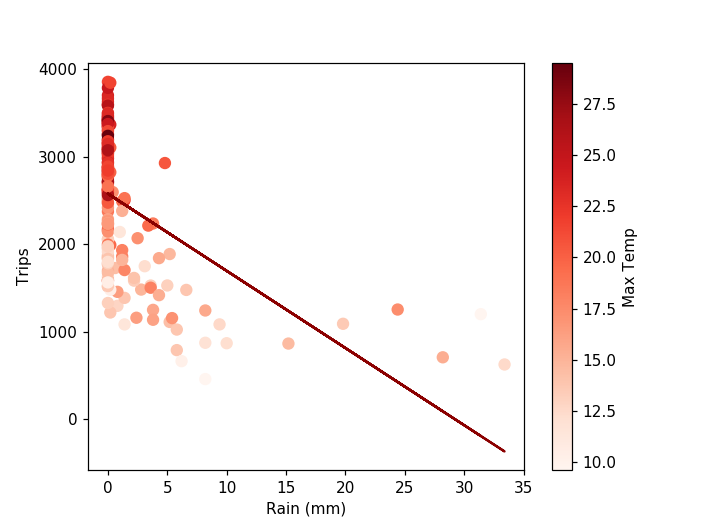

In [31]:
f,ax = plt.subplots()
wdf.plot('Total Rainmm','Trips',ax=ax,kind='scatter',cmap='Reds',c='Max Temp',s=50)
ax.set_xlabel('Rain (mm)')
f.savefig('trips_vs_rainfall.png')
ax.plot(wdf['Total Rainmm'],rainfit,c='darkred')

<IPython.core.display.Javascript object>


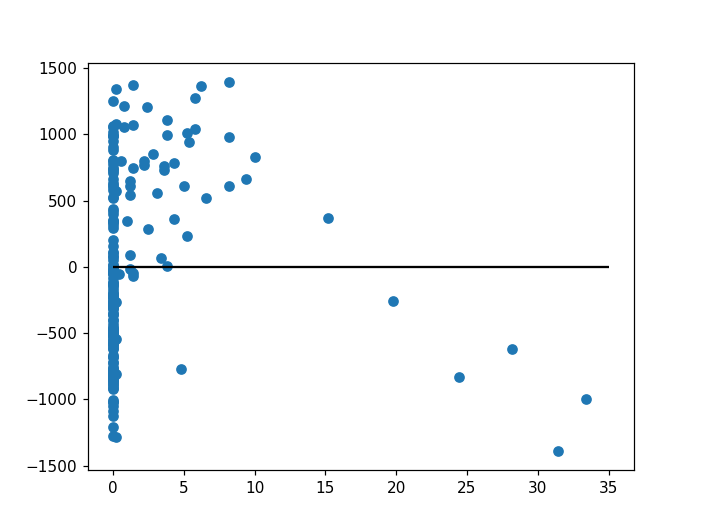

In [32]:
f,ax = plt.subplots()
ax.scatter(wdf['Total Rainmm'],rainfit-wdf['Trips'])
ax.hlines(0,0,35)

In [33]:
from scipy.stats import normaltest

In [34]:
normaltest(rainfit)

NormaltestResult(statistic=210.09470567685815, pvalue=2.3906407811994729e-46)

In [35]:
wdf['logRain'] = np.log(wdf['Total Rainmm']+0.01)

<IPython.core.display.Javascript object>


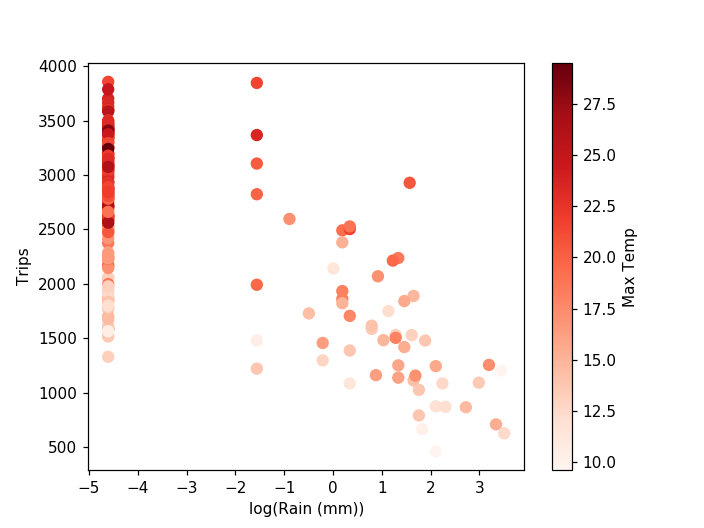

In [36]:
f,ax = plt.subplots()
wdf.plot('logRain','Trips',ax=ax,kind='scatter',cmap='Reds',c='Max Temp',s=50)
ax.set_xlabel('log(Rain (mm))')
f.savefig('trips_vs_lograin.png')

In [37]:
m = np.polyfit(wdf['logRain'],wdf['Trips'],1)

<IPython.core.display.Javascript object>


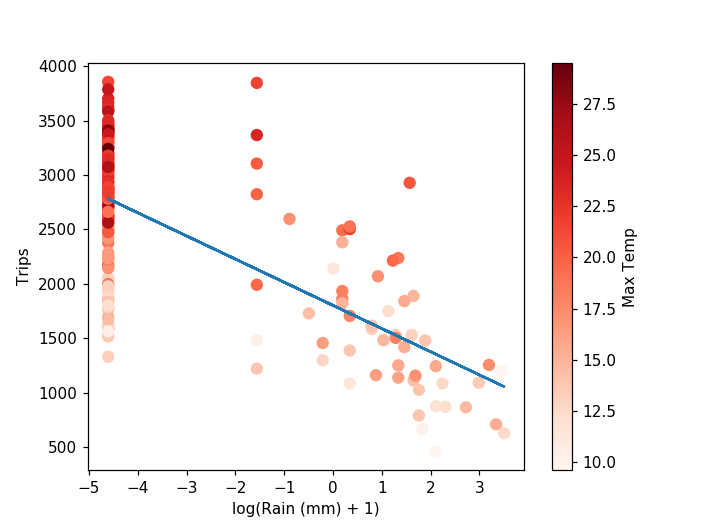

In [38]:
f,ax = plt.subplots()
wdf.plot('logRain','Trips',ax=ax,kind='scatter',cmap='Reds',c='Max Temp',s=50)
ax.set_xlabel('log(Rain (mm) + 1)')
ax.plot(wdf['logRain'],np.polyval(m,wdf['logRain']))
#f.savefig('trips_vs_lograin.png')

<IPython.core.display.Javascript object>


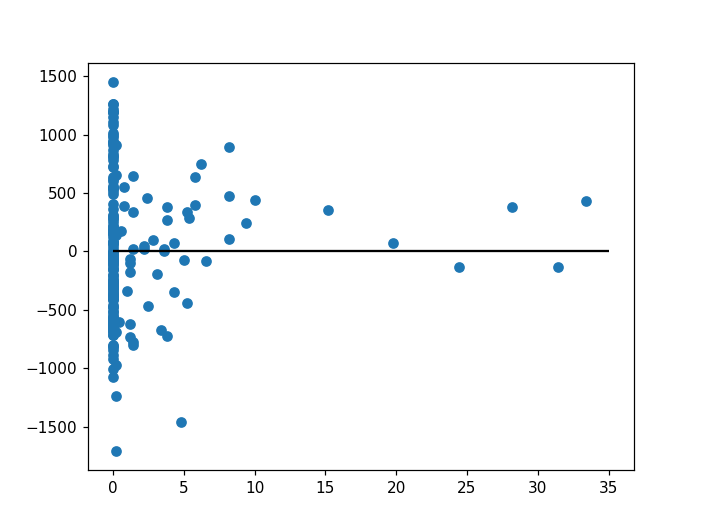

In [39]:
f,ax = plt.subplots()
ax.scatter(wdf['Total Rainmm'],np.polyval(m,wdf['logRain'])-wdf['Trips'])
plt.hlines(0,0,35)

<IPython.core.display.Javascript object>


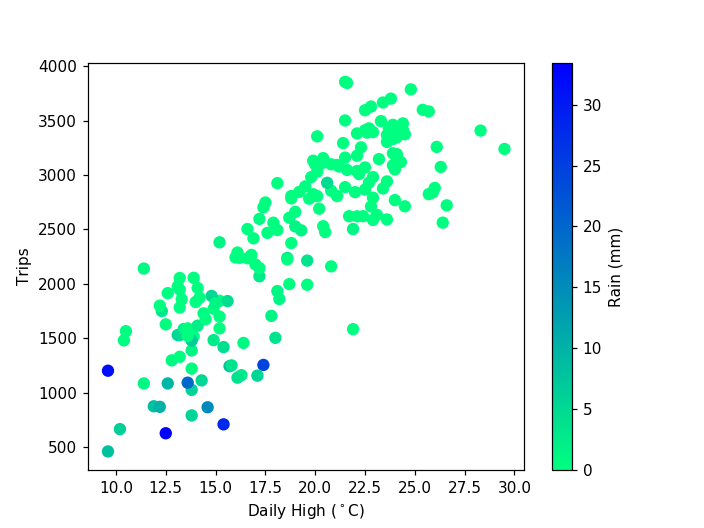

In [94]:
f,ax = plt.subplots()
wdf.plot('Max Temp','Trips',ax=ax,kind='scatter',cmap='winter_r',c='Total Rainmm',s=50)
ax.set_xlabel('Daily High ($^\circ$C)')
f.get_axes()[-1].set_ylabel('Rain (mm)')
f.savefig('trips_vs_temp.png')

<IPython.core.display.Javascript object>


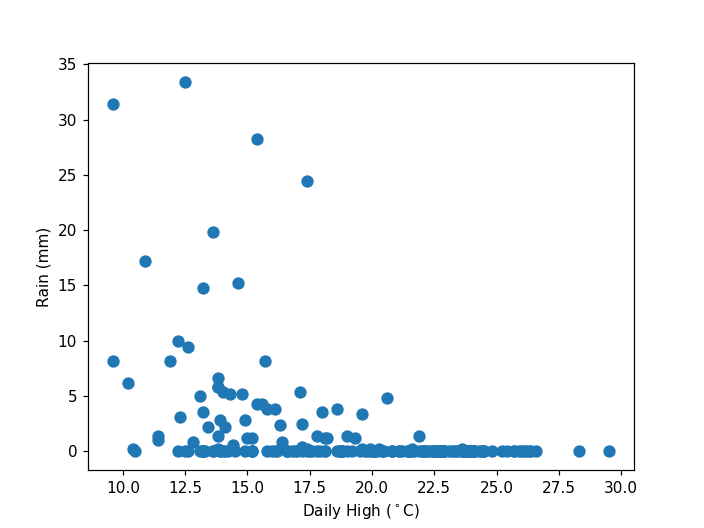

In [95]:
f,ax = plt.subplots()
wdf.plot('Max Temp','Total Rainmm',ax=ax,kind='scatter',s=50)
ax.set_xlabel('Daily High ($^\circ$C)')
f.get_axes()[-1].set_ylabel('Rain (mm)')
f.savefig('rain_vs_temp.png')

# Statsmodels Linear Regression
```
Trips ~ m1*Temp + m2*Rain + m3*isWeekday
```

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/msj/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## First, a simple model just accounting for rain, temperature and weekday vs weekend

In [47]:
wdf2 = sm.add_constant(wdf)

md = smf.OLS(wdf['Trips'],wdf2[['Max Temp','Total Rainmm','isWeekday','const']])

mdf = md.fit()

s = mdf.summary()

print(s)

                            OLS Regression Results                            
Dep. Variable:                  Trips   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     210.2
Date:                Tue, 21 Nov 2017   Prob (F-statistic):           2.38e-59
Time:                        13:56:33   Log-Likelihood:                -1394.8
No. Observations:                 189   AIC:                             2798.
Df Residuals:                     185   BIC:                             2811.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Max Temp       138.4343      6.975     19.847   

<IPython.core.display.Javascript object>


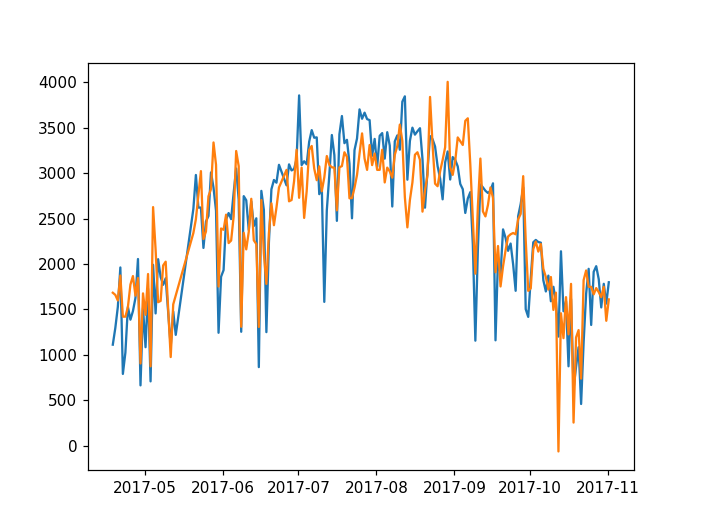

In [48]:
wdf['Trips Predicted'] = mdf.predict(wdf2[['Max Temp','Total Rainmm','isWeekday','const']])
f,ax = plt.subplots()
ax.plot(wdf['Trips'])
ax.plot(wdf['Trips Predicted'])


<IPython.core.display.Javascript object>


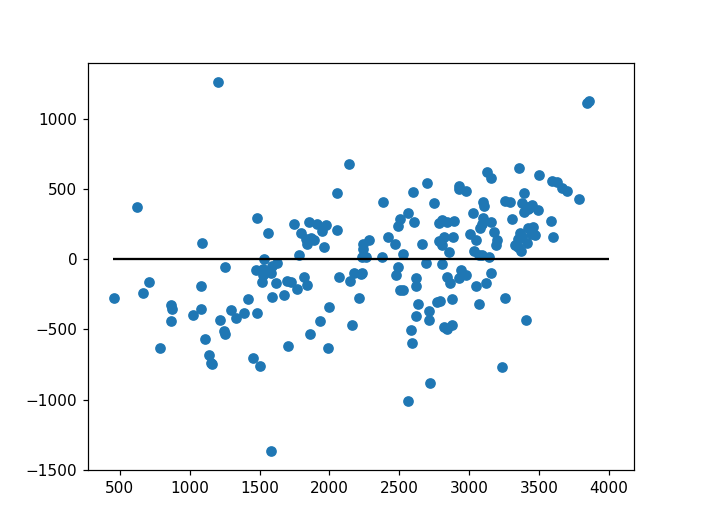

NormaltestResult(statistic=4.5832530934180937, pvalue=0.10110188110903791)

In [49]:
plt.figure()
plt.scatter(wdf['Trips'],mdf.resid)
plt.hlines(0,450,4000)
plt.gcf().savefig('ols_linlin_resids.png')
normaltest(mdf.resid)

## Now add wind, day of week, wet vs dry and holidays. 

In [51]:
cols = ['Max Temp', 'Total Rainmm','Spd of Max Gustkm/h', 
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Dry','Holiday']

md2 = smf.OLS(wdf['Trips'],wdf[cols])

mdf2 = md2.fit()

s = mdf2.summary()

print(s)

                            OLS Regression Results                            
Dep. Variable:                  Trips   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     67.07
Date:                Tue, 21 Nov 2017   Prob (F-statistic):           3.59e-57
Time:                        13:57:14   Log-Likelihood:                -1379.8
No. Observations:                 189   AIC:                             2784.
Df Residuals:                     177   BIC:                             2823.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Max Temp              126.6582    

<IPython.core.display.Javascript object>


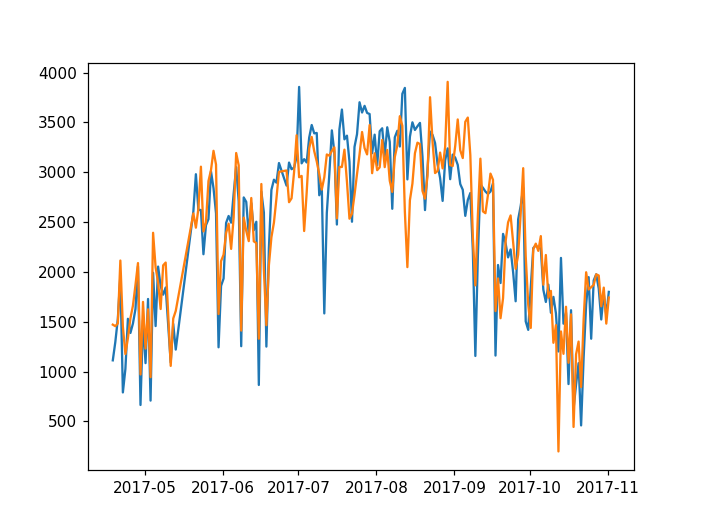

In [52]:
wdf['Trips Predicted2'] = mdf2.predict(wdf[cols])
f,ax = plt.subplots()
ax.plot(wdf['Trips'])
ax.plot(wdf['Trips Predicted2'])

In [53]:
mdf.rsquared_adj

0.76953414734813186

In [54]:
mdf2.rsquared_adj

0.79448927521599111

<IPython.core.display.Javascript object>


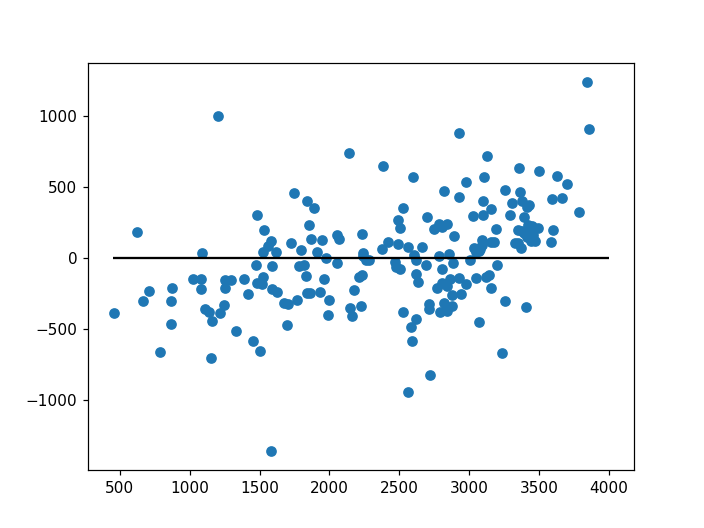

NormaltestResult(statistic=7.5111801905263915, pvalue=0.023386646187512416)

In [55]:
plt.figure()
plt.scatter(wdf['Trips'],mdf2.resid)
plt.hlines(0,450,4000)
plt.gcf().savefig('ols_linlog_resids2.png')
normaltest(mdf2.resid)

<IPython.core.display.Javascript object>


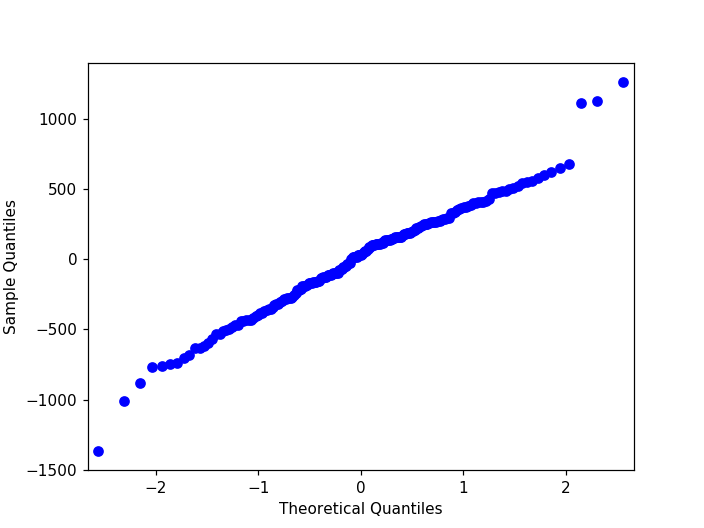

<IPython.core.display.Javascript object>


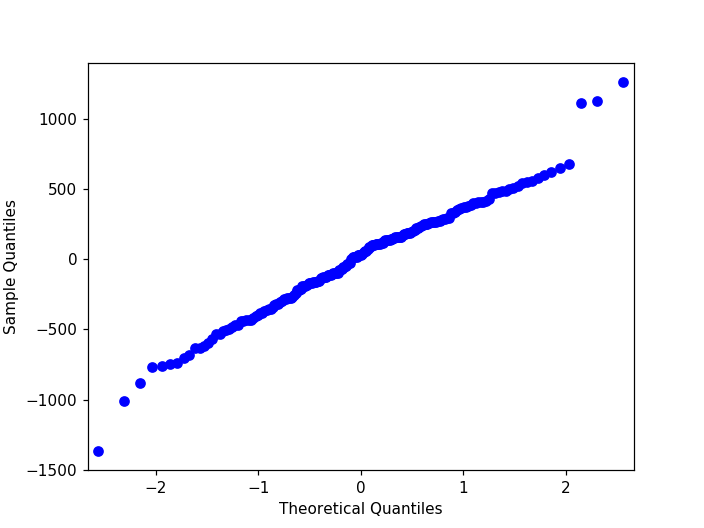

In [56]:
sm.qqplot(mdf.resid)

In [57]:
d = pd.datetime(2000, 12, 21)

## Add daylight

Hours of daylight could also affect bike usage. Function taken from https://github.com/jakevdp/PythonDataScienceHandbook

In [58]:
def hours_of_daylight(date, axis=23.44, latitude=49.):
    """Compute the hours of daylight for the given date"""
    
    days = (date - pd.datetime(2015, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

wdf['daylight_hrs'] = list(map(hours_of_daylight, wdf.index.tz_localize(None)))

In [59]:
wdf['daylight_hrs']

Day
2017-04-18 00:00:00-07:00    13.666948
2017-04-19 00:00:00-07:00    13.725229
2017-04-20 00:00:00-07:00    13.783220
2017-04-21 00:00:00-07:00    13.840906
2017-04-22 00:00:00-07:00    13.898273
2017-04-23 00:00:00-07:00    13.955305
2017-04-24 00:00:00-07:00    14.011987
2017-04-25 00:00:00-07:00    14.068302
2017-04-26 00:00:00-07:00    14.124234
2017-04-27 00:00:00-07:00    14.179766
2017-04-28 00:00:00-07:00    14.234880
2017-04-29 00:00:00-07:00    14.289560
2017-04-30 00:00:00-07:00    14.343785
2017-05-01 00:00:00-07:00    14.397538
2017-05-02 00:00:00-07:00    14.450799
2017-05-03 00:00:00-07:00    14.503549
2017-05-04 00:00:00-07:00    14.555768
2017-05-05 00:00:00-07:00    14.607434
2017-05-06 00:00:00-07:00    14.658528
2017-05-07 00:00:00-07:00    14.709027
2017-05-08 00:00:00-07:00    14.758910
2017-05-09 00:00:00-07:00    14.808154
2017-05-11 00:00:00-07:00    14.904638
2017-05-12 00:00:00-07:00    14.951830
2017-05-13 00:00:00-07:00    14.998293
2017-05-20 00:00:00-0

In [60]:
cols2 = ['Max Temp', 'Total Rainmm', 
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Dry','Holiday','daylight_hrs']

md3 = smf.OLS(wdf['Trips'],wdf[cols2])

mdf3 = md3.fit()

s = mdf3.summary()

print(s)

                            OLS Regression Results                            
Dep. Variable:                  Trips   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     69.65
Date:                Tue, 21 Nov 2017   Prob (F-statistic):           2.49e-58
Time:                        13:57:32   Log-Likelihood:                -1376.9
No. Observations:                 189   AIC:                             2778.
Df Residuals:                     177   BIC:                             2817.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Max Temp       117.3302      8.079     14.522   

In [134]:
wdf['Trips Predicted3'] = mdf3.predict(wdf[cols])
f,ax = plt.subplots()
ax.plot(wdf['Trips'],label='Measured')
ax.plot(wdf['Trips Predicted3'],label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Trips')
ax.legend()
f.savefig('/Users/msj/Dropbox/mobi/trip_vs_predicted_full_model.png')

KeyError: "['Dry'] not in index"

<IPython.core.display.Javascript object>


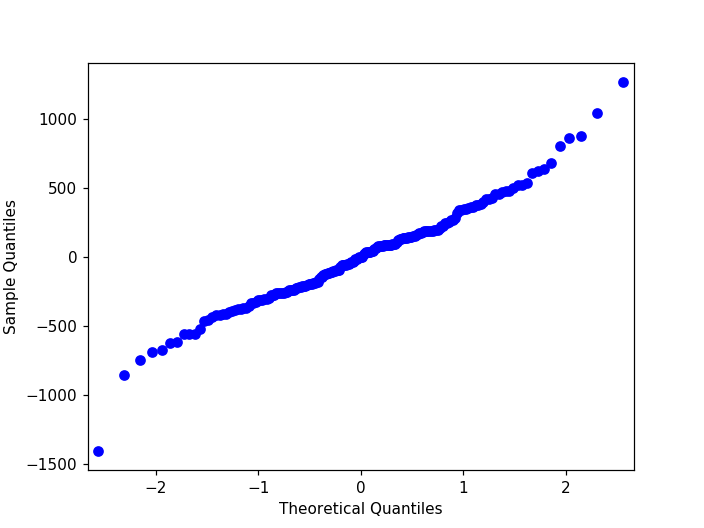

In [62]:
f,ax = plt.subplots()
sm.qqplot(mdf3.resid,ax=ax)
f.savefig('/Users/msj/Dropbox/mobi/qqplot.png')

# Outlier checks

In [69]:
wdf[(mdf3.resid > 1000) | (mdf3.resid < -1000)][cols2+['Trips','Trips Predicted3']]

,Max Temp,Total Rainmm,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Dry,Holiday,daylight_hrs,Trips,Trips Predicted3
Day,,,,,,,,,,,,,,
2017-07-11 00:00:00-07:00,21.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,15.702729,1583.0,2949.059880
2017-08-12 00:00:00-07:00,21.6,0.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,14.330272,3846.0,2604.081174
2017-10-12 00:00:00-07:00,9.6,31.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,10.665647,1201.0,197.852458


In [68]:
wdf['Spd of Max Gustkm/h'].mean()

34.444444444444443

In [64]:
wdf[mdf3.resid < -1000][cols+['Trips','Trips Predicted3']]

,Max Temp,Total Rainmm,Spd of Max Gustkm/h,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Dry,Holiday,Trips,Trips Predicted3
Day,,,,,,,,,,,,,,
2017-07-11 00:00:00-07:00,21.9,0.0,41.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,1583.0,2949.05988


In [65]:
thdf = pd.read_pickle('/Users/msj/Dropbox/mobi/taken_hourly_df.p')

In [66]:
thdf['2017-07-11'].sum(1)

time
2017-07-11 00:00:00-07:00     20.0
2017-07-11 01:00:00-07:00      2.0
2017-07-11 02:00:00-07:00      2.0
2017-07-11 04:00:00-07:00      5.0
2017-07-11 05:00:00-07:00      5.0
2017-07-11 06:00:00-07:00     44.0
2017-07-11 07:00:00-07:00    106.0
2017-07-11 08:00:00-07:00    239.0
2017-07-11 09:00:00-07:00    197.0
2017-07-11 10:00:00-07:00    143.0
2017-07-11 11:00:00-07:00    149.0
2017-07-11 12:00:00-07:00    156.0
2017-07-11 13:00:00-07:00    166.0
2017-07-11 14:00:00-07:00    183.0
2017-07-11 15:00:00-07:00    120.0
2017-07-11 16:00:00-07:00     17.0
2017-07-11 17:00:00-07:00      3.0
2017-07-11 20:00:00-07:00     22.0
2017-07-11 22:00:00-07:00      4.0
dtype: float64

# Use the model to predict November trips

In [122]:
thdfn = pd.read_pickle('taken_hourly_df.p')
thdfn = thdfn.loc['2017-11-01':]

In [130]:
wdfn = get_weather_range((2017,11),(2017,11)).fillna(method='pad')
wdfn = wdfn.tz_localize('US/Pacific') # Needs to match mobi df or they won't interact well
wdfn.head()

,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rainmm,Total Snowcm,Total Precipmm,Snow on Grndcm,Dir of Max Gust10's deg,Spd of Max Gustkm/h
Day,,,,,,,,,,,
2017-11-01 00:00:00-07:00,12.2,2.4,7.3,10.7,0.0,NaN,0.0,NaN,NaN,27.0,39.0
2017-11-02 00:00:00-07:00,8.8,2.4,5.6,12.4,0.0,20.8,0.0,20.8,NaN,12.0,46.0
2017-11-03 00:00:00-07:00,4.3,-1.3,1.5,16.5,0.0,0.4,0.0,0.4,NaN,9.0,37.0
2017-11-04 00:00:00-07:00,2.1,-2.1,0.0,18.0,0.0,0.0,0.0,0.4,NaN,10.0,24.0
2017-11-05 00:00:00-07:00,6.7,-0.4,3.2,14.8,0.0,0.0,0.0,0.0,NaN,6.0,24.0


In [131]:
wdfn = wdfn.tz_localize(None)
thdfn = thdfn.tz_localize(None)

In [132]:
wdfn['Trips'] = thdfn.groupby(pd.TimeGrouper(freq='D')).sum().sum(1)

In [133]:
wdfn

,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Rainmm,Total Snowcm,Total Precipmm,Snow on Grndcm,Dir of Max Gust10's deg,Spd of Max Gustkm/h,Trips
Day,,,,,,,,,,,,
2017-11-01,12.2,2.4,7.3,10.7,0.0,NaN,0.0,NaN,NaN,27.0,39.0,1799.0
2017-11-02,8.8,2.4,5.6,12.4,0.0,20.8,0.0,20.8,NaN,12.0,46.0,726.0
2017-11-03,4.3,-1.3,1.5,16.5,0.0,0.4,0.0,0.4,NaN,9.0,37.0,1352.0
2017-11-04,2.1,-2.1,0.0,18.0,0.0,0.0,0.0,0.4,NaN,10.0,24.0,755.0
2017-11-05,6.7,-0.4,3.2,14.8,0.0,0.0,0.0,0.0,NaN,6.0,24.0,1065.0
2017-11-06,6.5,-4.3,1.1,16.9,0.0,0.0,0.0,0.0,NaN,7.0,22.0,1460.0
2017-11-07,6.5,-4.3,1.1,16.9,0.0,0.0,0.0,0.0,NaN,7.0,22.0,1338.0
2017-11-08,6.5,-4.3,1.1,16.9,0.0,0.0,0.0,0.0,NaN,21.0,30.0,1520.0
2017-11-09,9.4,6.0,7.7,10.3,0.0,3.6,0.0,3.6,NaN,23.0,35.0,1179.0


In [136]:
wdfn['daylight_hrs'] = list(map(hours_of_daylight, wdfn.index.tz_localize(None)))

In [137]:
wdfn['Dry'] = (wdfn['Total Rainmm']==0).astype(int)

In [138]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    wdfn[days[i]] = (wdfn.index.dayofweek == i).astype(float)

In [140]:
wdfn['Holiday'] = 0
wdfn.loc['2017-11-13','Holiday'] = 1

In [143]:
wdfn['Trips Predicted'] = mdf2.predict(wdfn[cols])

<IPython.core.display.Javascript object>


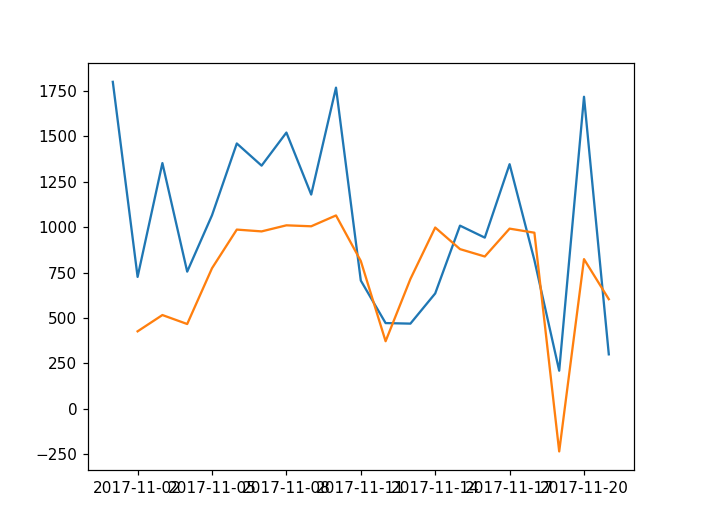

In [144]:
f,ax = plt.subplots()
ax.plot(wdfn['Trips'])
ax.plot(wdfn['Trips Predicted'])